In [1]:
import sys
import os
sys.path.append('/Users/mbassalaev/Desktop/audio_project/Spotter_recognition/')

import pandas as pd
import pickle
import numpy as np

from keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras import backend as K
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical

from service.data_augmentation import make_batch, load_background, normalize_df
from models.crnn import CRNN_model
from tensorflow.python.ops import gen_audio_ops as audio_ops
from sklearn.metrics import classification_report
import tensorflow as tf

In [2]:
df = pd.read_csv(os.path.abspath('../data/full_df'))

In [3]:
df_train, df_test = train_test_split(df, shuffle=True, test_size=6464, train_size = 58240, random_state=42)

In [4]:
model = CRNN_model((49, 20, 1), 11)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 20, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 18, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 16, 16)        3856      
_________________________________________________________________
reshape (Reshape)            (None, 43, 256)           0         
_________________________________________________________________
gru (GRU)                    (None, 256)               394752    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [6]:
opt = optimizers.Adam(0.001)
model.compile(optimizer = opt, loss=CategoricalCrossentropy(from_logits=True), metrics = ["accuracy"])

In [7]:
filename = os.path.abspath('../../spotter_data_service/lb')
outfile = open(filename,'rb')
lb = pickle.load(outfile)
outfile.close()

In [8]:
background_folder = os.path.abspath('../../../spotter_data/_background_noise_/')

In [9]:
train_metrics = []
test_metrics = []

noise_to_data = load_background(background_folder)
sr = 16000

p_aug = {
    'gaussian': 1,
    'stretch': 0.3,
    'pitch_shift': 0.3,
    'shift': 0.3,
    'clipping': 0.3,
    'time_mask': 0.5,
    'freq_mask': 0.5
}

X_test, Y_test = normalize_df(df_test, lb, sr, "tensorflow")

start_step = 1
training_steps_list = [20000, 20000, 20000, 20000]
learning_rates_list = [0.001,0.0005,0.0001,0.00002]
training_steps_max = np.sum(training_steps_list)
lr_init = learning_rates_list[0]
exp_rate = -np.log(learning_rates_list[-1] / lr_init) / training_steps_max

In [10]:
for step in range(0, 5000):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 4s 35ms/step - loss: 2.1495 - accuracy: 0.5879
Current step is 50
Train metrics = [2.0340569019317627, 0.5625], Test metrics = [2.149460792541504, 0.5878713130950928]
101/101 [==============================] - 4s 37ms/step - loss: 1.6534 - accuracy: 0.6303
Current step is 100
Train metrics = [1.5686695575714111, 0.640625], Test metrics = [1.6533546447753906, 0.6302598714828491]
101/101 [==============================] - 4s 37ms/step - loss: 1.5563 - accuracy: 0.6153
Current step is 150
Train metrics = [1.5424261093139648, 0.609375], Test metrics = [1.5563173294067383, 0.6152536869049072]
101/101 [==============================] - 4s 37ms/step - loss: 1.5035 - accuracy: 0.6303
Current step is 200
Train metrics = [1.292342185974121, 0.6875], Test metrics = [1.5035383701324463, 0.6302598714828491]
101/101 [==============================] - 4s 37ms/step - loss: 1.4797 - accuracy: 0.6303
Current step is 250
Train metrics = [1.3049105405807495, 0.70

In [11]:
for step in range(0, 2500):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 4s 37ms/step - loss: 0.2816 - accuracy: 0.9098
Current step is 50
Train metrics = [0.6038098335266113, 0.78125], Test metrics = [0.28163859248161316, 0.9098081588745117]
101/101 [==============================] - 4s 37ms/step - loss: 0.2535 - accuracy: 0.9174
Current step is 100
Train metrics = [0.6323760747909546, 0.734375], Test metrics = [0.25349971652030945, 0.9173886179924011]
101/101 [==============================] - 4s 37ms/step - loss: 0.2741 - accuracy: 0.9086
Current step is 150
Train metrics = [0.6277962923049927, 0.8125], Test metrics = [0.27411624789237976, 0.9085705280303955]
101/101 [==============================] - 4s 38ms/step - loss: 0.2695 - accuracy: 0.9138
Current step is 200
Train metrics = [0.7469532489776611, 0.8125], Test metrics = [0.26946476101875305, 0.9138304591178894]
101/101 [==============================] - 4s 37ms/step - loss: 0.2388 - accuracy: 0.9225
Current step is 250
Train metrics = [0.6521384716033936,

In [13]:
K.set_value(model.optimizer.learning_rate, 0.0005)

for step in range(0, 2501):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 4s 37ms/step - loss: 0.1936 - accuracy: 0.9404
Current step is 50
Train metrics = [0.34635353088378906, 0.875], Test metrics = [0.19360530376434326, 0.9404393434524536]
101/101 [==============================] - 4s 37ms/step - loss: 0.1632 - accuracy: 0.9497
Current step is 100
Train metrics = [0.31931251287460327, 0.890625], Test metrics = [0.163239523768425, 0.9497215151786804]
101/101 [==============================] - 4s 37ms/step - loss: 0.1698 - accuracy: 0.9469
Current step is 150
Train metrics = [0.2897743582725525, 0.9375], Test metrics = [0.1697801798582077, 0.9469369053840637]
101/101 [==============================] - 4s 37ms/step - loss: 0.1517 - accuracy: 0.9510
Current step is 200
Train metrics = [0.4639308750629425, 0.84375], Test metrics = [0.1517239212989807, 0.9509591460227966]
101/101 [==============================] - 4s 38ms/step - loss: 0.1668 - accuracy: 0.9465
Current step is 250
Train metrics = [0.4813620448112488, 0.

In [14]:
K.set_value(model.optimizer.learning_rate, 0.00025)

for step in range(0, 2501):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 4s 37ms/step - loss: 0.1387 - accuracy: 0.9558
Current step is 50
Train metrics = [0.3863911032676697, 0.90625], Test metrics = [0.13874542713165283, 0.9557549357414246]
101/101 [==============================] - 4s 37ms/step - loss: 0.1403 - accuracy: 0.9567
Current step is 100
Train metrics = [0.27318984270095825, 0.90625], Test metrics = [0.1402510404586792, 0.9566831588745117]
101/101 [==============================] - 4s 37ms/step - loss: 0.1370 - accuracy: 0.9581
Current step is 150
Train metrics = [0.2605178952217102, 0.90625], Test metrics = [0.13699762523174286, 0.9580755233764648]
101/101 [==============================] - 4s 37ms/step - loss: 0.1376 - accuracy: 0.9595
Current step is 200
Train metrics = [0.5773183107376099, 0.8125], Test metrics = [0.1376200169324875, 0.9594678282737732]
101/101 [==============================] - 4s 37ms/step - loss: 0.1456 - accuracy: 0.9553
Current step is 250
Train metrics = [0.34746113419532776,

In [19]:
K.set_value(model.optimizer.learning_rate, 0.00025)

for step in range(0, 2501):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 34ms/step - loss: 0.1298 - accuracy: 0.9599
Current step is 50
Train metrics = [0.2763735353946686, 0.890625], Test metrics = [0.12982796132564545, 0.9599319100379944]
101/101 [==============================] - 4s 35ms/step - loss: 0.1334 - accuracy: 0.9590
Current step is 100
Train metrics = [0.32118815183639526, 0.875], Test metrics = [0.13344380259513855, 0.9590036869049072]
101/101 [==============================] - 4s 35ms/step - loss: 0.1335 - accuracy: 0.9595
Current step is 150
Train metrics = [0.49263668060302734, 0.796875], Test metrics = [0.13352440297603607, 0.9594678282737732]
101/101 [==============================] - 4s 35ms/step - loss: 0.1365 - accuracy: 0.9585
Current step is 200
Train metrics = [0.47941815853118896, 0.84375], Test metrics = [0.13646867871284485, 0.958539605140686]
101/101 [==============================] - 4s 35ms/step - loss: 0.1334 - accuracy: 0.9595
Current step is 250
Train metrics = [0.34341886639595

In [20]:
K.set_value(model.optimizer.learning_rate, 0.0001)

for step in range(0, 2501):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 4s 36ms/step - loss: 0.1229 - accuracy: 0.9619
Current step is 50
Train metrics = [0.343296617269516, 0.90625], Test metrics = [0.12292089313268661, 0.9619430899620056]
101/101 [==============================] - 4s 36ms/step - loss: 0.1215 - accuracy: 0.9641
Current step is 100
Train metrics = [0.3059648275375366, 0.890625], Test metrics = [0.12151487171649933, 0.9641088843345642]
101/101 [==============================] - 4s 36ms/step - loss: 0.1193 - accuracy: 0.9649
Current step is 150
Train metrics = [0.5933306217193604, 0.8125], Test metrics = [0.11928557604551315, 0.9648824334144592]
101/101 [==============================] - 4s 36ms/step - loss: 0.1206 - accuracy: 0.9623
Current step is 200
Train metrics = [0.385854035615921, 0.875], Test metrics = [0.12056159973144531, 0.9622524976730347]
101/101 [==============================] - 4s 37ms/step - loss: 0.1227 - accuracy: 0.9626
Current step is 250
Train metrics = [0.19798585772514343, 0

In [27]:
temp = np.arange(50, 19901, 50)

test_acc =[x[1] for x in test_metrics]
test_loss = [x[0] for x in test_metrics]

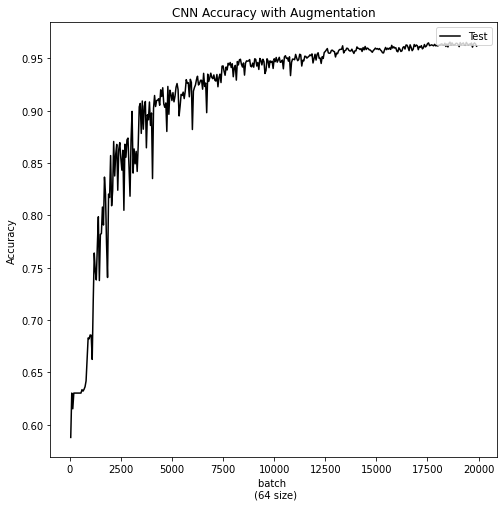

In [34]:
fig = plt.figure(figsize=(8,8))
test_plot = plt.plot(temp, test_acc, color='black', label='Test')
plt.title('CNN Accuracy with Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('batch \n (64 size)')
plt.legend(loc='upper right')
plt.savefig("CNN_acc_with_aug.jpg", facecolor=fig.get_facecolor(), transparent=True)
plt.show()

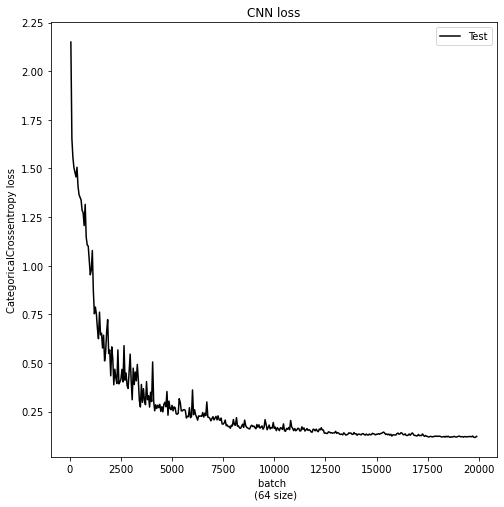

In [33]:
plt.figure(figsize=(8,8))
test_plot = plt.plot(temp, test_loss, color='black', label='Test')
plt.title('CNN loss')
plt.ylabel('CategoricalCrossentropy loss')
plt.xlabel('batch \n (64 size)')
plt.legend(loc='upper right')
plt.savefig("CNN_loss_with_aug.jpg", facecolor=fig.get_facecolor(), transparent=True)
plt.show()

In [30]:
model.save(os.path.join(os.getcwd(), 'CNN.h5'), save_format="h5")

In [31]:
def report(model, X, y, classes):
    model_predictions = model.predict(X, batch_size=64).argmax(axis=1)
    true_predictions = y.argmax(axis=1)
    return classification_report(true_predictions, model_predictions, target_names=classes)

In [32]:
print(report(model, X_test, Y_test, lb.classes_))

              precision    recall  f1-score   support

        down       0.94      0.96      0.95       254
          go       0.93      0.79      0.85       229
        left       0.96      0.91      0.93       236
          no       0.92      0.90      0.91       242
         off       0.96      0.89      0.92       226
          on       0.93      0.95      0.94       229
       right       0.96      0.96      0.96       251
        stop       0.97      0.96      0.96       234
      unkown       0.97      0.99      0.98      4074
          up       0.94      0.91      0.92       250
         yes       0.97      0.97      0.97       239

    accuracy                           0.96      6464
   macro avg       0.95      0.93      0.94      6464
weighted avg       0.96      0.96      0.96      6464



In [2]:
dnn_model = tf.keras.models.load_model(os.path.join(os.getcwd(), '../saved_models/DNN.h5'))
att_rnn_model = tf.keras.models.load_model(os.path.join(os.getcwd(), '../saved_models/ATT_RNN.h5'))
crnn_model = tf.keras.models.load_model(os.path.join(os.getcwd(), '../saved_models/CRNN.h5'))
cnn_model = tf.keras.models.load_model(os.path.join(os.getcwd(), '../saved_models/CNN.h5'))

In [3]:
crnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 49, 20, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (64, 47, 18, 16)          160       
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 43, 16, 16)          3856      
_________________________________________________________________
reshape (Reshape)            (64, 43, 256)             0         
_________________________________________________________________
gru (GRU)                    (64, 256)                 394752    
_________________________________________________________________
flatten (Flatten)            (64, 256)                 0         
_________________________________________________________________
dropout (Dropout)            (64, 256)                 0     

In [4]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 20, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 49, 20, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 49, 20, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 49, 20, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 10, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 10, 64)        61504     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 10, 64)        256   

In [36]:
print(report(crnn_model, X_test, Y_test, lb.classes_))

              precision    recall  f1-score   support

        down       0.98      0.95      0.97       254
          go       0.96      0.88      0.92       229
        left       0.98      0.94      0.96       236
          no       0.94      0.95      0.94       242
         off       0.99      0.92      0.95       226
          on       0.94      0.94      0.94       229
       right       0.96      0.95      0.96       251
        stop       0.96      0.94      0.95       234
      unkown       0.98      0.99      0.98      4074
          up       0.93      0.96      0.95       250
         yes       0.99      0.97      0.98       239

    accuracy                           0.97      6464
   macro avg       0.96      0.95      0.95      6464
weighted avg       0.97      0.97      0.97      6464



In [37]:
print(report(crnn_model, X_test, Y_test, lb.classes_))

              precision    recall  f1-score   support

        down       0.95      0.96      0.96       254
          go       0.95      0.86      0.90       229
        left       0.97      0.94      0.95       236
          no       0.93      0.94      0.93       242
         off       0.99      0.88      0.93       226
          on       0.97      0.93      0.95       229
       right       0.94      0.93      0.94       251
        stop       0.96      0.93      0.94       234
      unkown       0.97      0.98      0.98      4074
          up       0.92      0.93      0.92       250
         yes       0.99      0.97      0.98       239

    accuracy                           0.96      6464
   macro avg       0.96      0.93      0.94      6464
weighted avg       0.96      0.96      0.96      6464



In [18]:
test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)

101/101 [==============================] - 4s 37ms/step - loss: 0.1344 - accuracy: 0.9585


In [39]:
crnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 49, 20, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (64, 47, 18, 16)          160       
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 43, 16, 16)          3856      
_________________________________________________________________
reshape (Reshape)            (64, 43, 256)             0         
_________________________________________________________________
gru (GRU)                    (64, 256)                 394752    
_________________________________________________________________
flatten (Flatten)            (64, 256)                 0         
_________________________________________________________________
dropout (Dropout)            (64, 256)                 0     